<a href="https://colab.research.google.com/github/mithleshsingla/MRI_Brain_Tumor_detection_and_segmentaton/blob/main/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORT LIBRARIES AND DATASETS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [2]:
from google.colab import drive



In [3]:

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/brain_tumor


/content/drive/MyDrive/brain_tumor


In [5]:
# data containing path to Brain MRI and their corresponding mask
brain_df = pd.read_csv('data_mask.csv')

In [6]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [7]:
brain_df.head(50)

patient_id                                         image_path  \
0   TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1   TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2   TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3   TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4   TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   
5   TCGA_CS_5395_19981004  TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif   
6   TCGA_CS_5395_19981004  TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif   
7   TCGA_CS_5395_19981004  TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1.tif   
8   TCGA_CS_5395_19981004  TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1.tif   
9   TCGA_CS_5395_19981004  TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1.tif   
10  TCGA_CS_5395_19981004  TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_1.tif   
11  TCGA_CS_5395_19981004  TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_1.tif   
12  TCGA_CS_5395_19981004  TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_1.tif   
13  TCGA_CS_5395_19981004  TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_1.tif   
14  TCGA_CS_5395_19981004  TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_1.tif   
15  TCGA_CS_5395_19981004  TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_1.tif   
16  TCGA_CS_5395_19981004  TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_1.tif   
17  TCGA_CS_5395_19981004  TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_1.tif   
18  TCGA_CS_5395_19981004  TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_1.tif   
19  TCGA_CS_5395_19981004  TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_1.tif   
20  TCGA_CS_4944_20010208  TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_1.tif   
21  TCGA_CS_4944_20010208  TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_1.tif   
22  TCGA_CS_4944_20010208  TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_1.tif   
23  TCGA_CS_4944_20010208  TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_1.tif   
24  TCGA_CS_4944_20010208  TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_1.tif   
25  TCGA_CS_4944_20010208  TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_1.tif   
26  TCGA_CS_4944_20010208  TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_1.tif   
27  TCGA_CS_4944_20010208  TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_1.tif   
28  TCGA_CS_4944_20010208  TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_1.tif   
29  TCGA_CS_4944_20010208  TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_1.tif   
30  TCGA_CS_4944_20010208  TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_1.tif   
31  TCGA_CS_4944_20010208  TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_1.tif   
32  TCGA_CS_4944_20010208  TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_1.tif   
33  TCGA_CS_4944_20010208  TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_1.tif   
34  TCGA_CS_4944_20010208  TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_1.tif   
35  TCGA_CS_4944_20010208  TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_1.tif   
36  TCGA_CS_4944_20010208  TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_1.tif   
37  TCGA_CS_4944_20010208  TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_1.tif   
38  TCGA_CS_4944_20010208  TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1.tif   
39  TCGA_CS_4944_20010208  TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif   
40  TCGA_CS_4941_19960909  TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_1.tif   
41  TCGA_CS_4941_19960909  TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_1.tif   
42  TCGA_CS_4941_19960909  TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_1.tif   
43  TCGA_CS_4941_19960909  TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1.tif   
44  TCGA_CS_4941_19960909  TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_1.tif   
45  TCGA_CS_4941_19960909  TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_1.tif   
46  TCGA_CS_4941_19960909  TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_1.tif   
47  TCGA_CS_4941_19960909  TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_1.tif   
48  TCGA_CS_4941_19960909  TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_1.tif   
49  TCGA_CS_494

In [8]:
brain_df.mask_path[1] # Path to the brain MRI image

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [9]:
brain_df.image_path[1] # Path to the segmentation mask

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

In [10]:
# Obtain the number of images with mask
brain_df['mask'].value_counts()

mask
0    2556
1    1373
Name: count, dtype: int64

## DATA VISUALIZATION

In [11]:
brain_df

patient_id  \
0     TCGA_CS_5395_19981004   
1     TCGA_CS_5395_19981004   
2     TCGA_CS_5395_19981004   
3     TCGA_CS_5395_19981004   
4     TCGA_CS_5395_19981004   
...                     ...   
3924  TCGA_DU_6401_19831001   
3925  TCGA_DU_6401_19831001   
3926  TCGA_DU_6401_19831001   
3927  TCGA_DU_6401_19831001   
3928  TCGA_DU_6401_19831001   

                                             image_path  \
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   
...                                                 ...   
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...   
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...   
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...   
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...   
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...   

                                              mask_path  mask  
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0  
...                                                 ...   ...  
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...     0  
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...     0  
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...     0  
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...     0  
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...     0  

[3929 rows x 4 columns]

In [12]:
brain_df['mask'].value_counts().index

Index([0, 1], dtype='int64', name='mask')

In [13]:
# Use plotly to plot interactive bar chart
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

In [14]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [15]:
brain_df.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

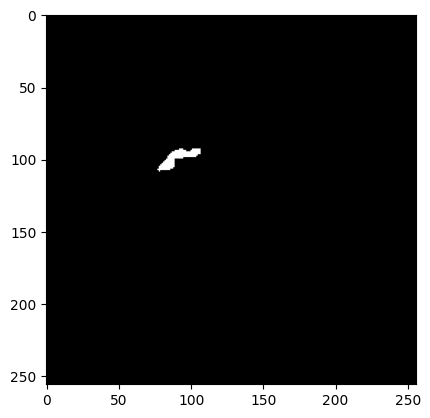

In [16]:
plt.imshow(cv2.imread(brain_df.mask_path[623]))

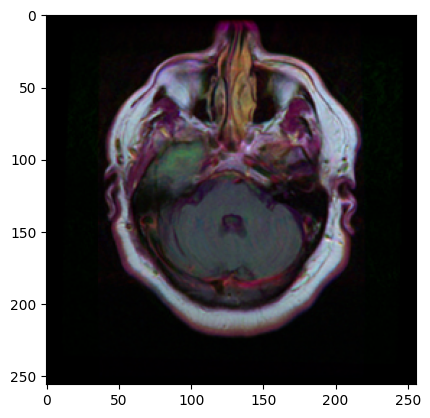

In [17]:
plt.imshow(cv2.imread(brain_df.image_path[623]))

In [18]:
cv2.imread(brain_df.mask_path[623]).max()

np.uint8(255)

In [19]:
cv2.imread(brain_df.mask_path[623]).min()

np.uint8(0)

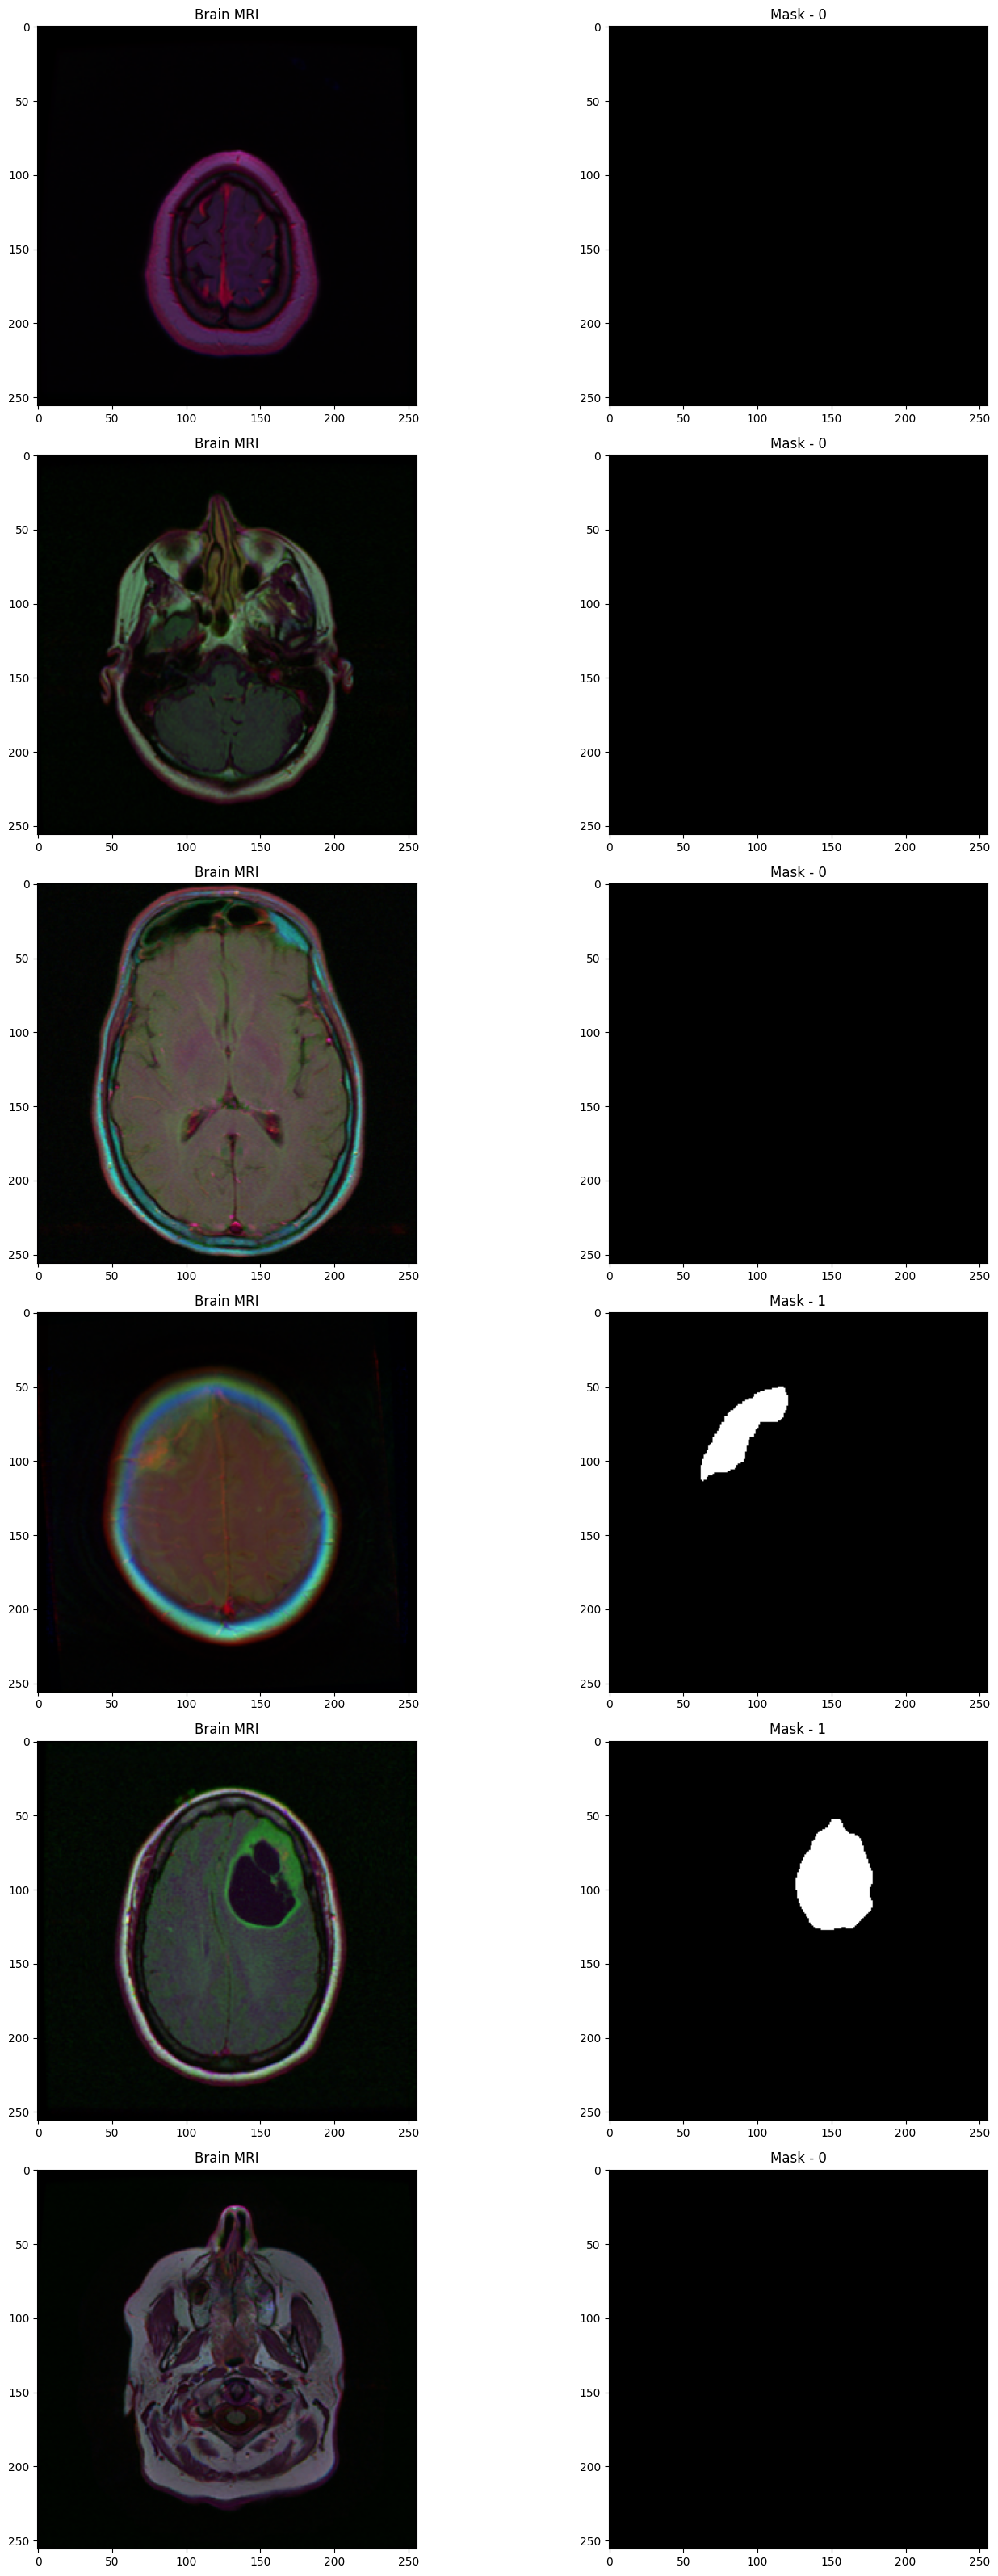

In [20]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()


  ### Plotting 12 randomly selected (1) MRI scan images from only sick patients followed by (2) corresponding mask, (3) both MRI image and the corresponding mask (in red color) on top of each other

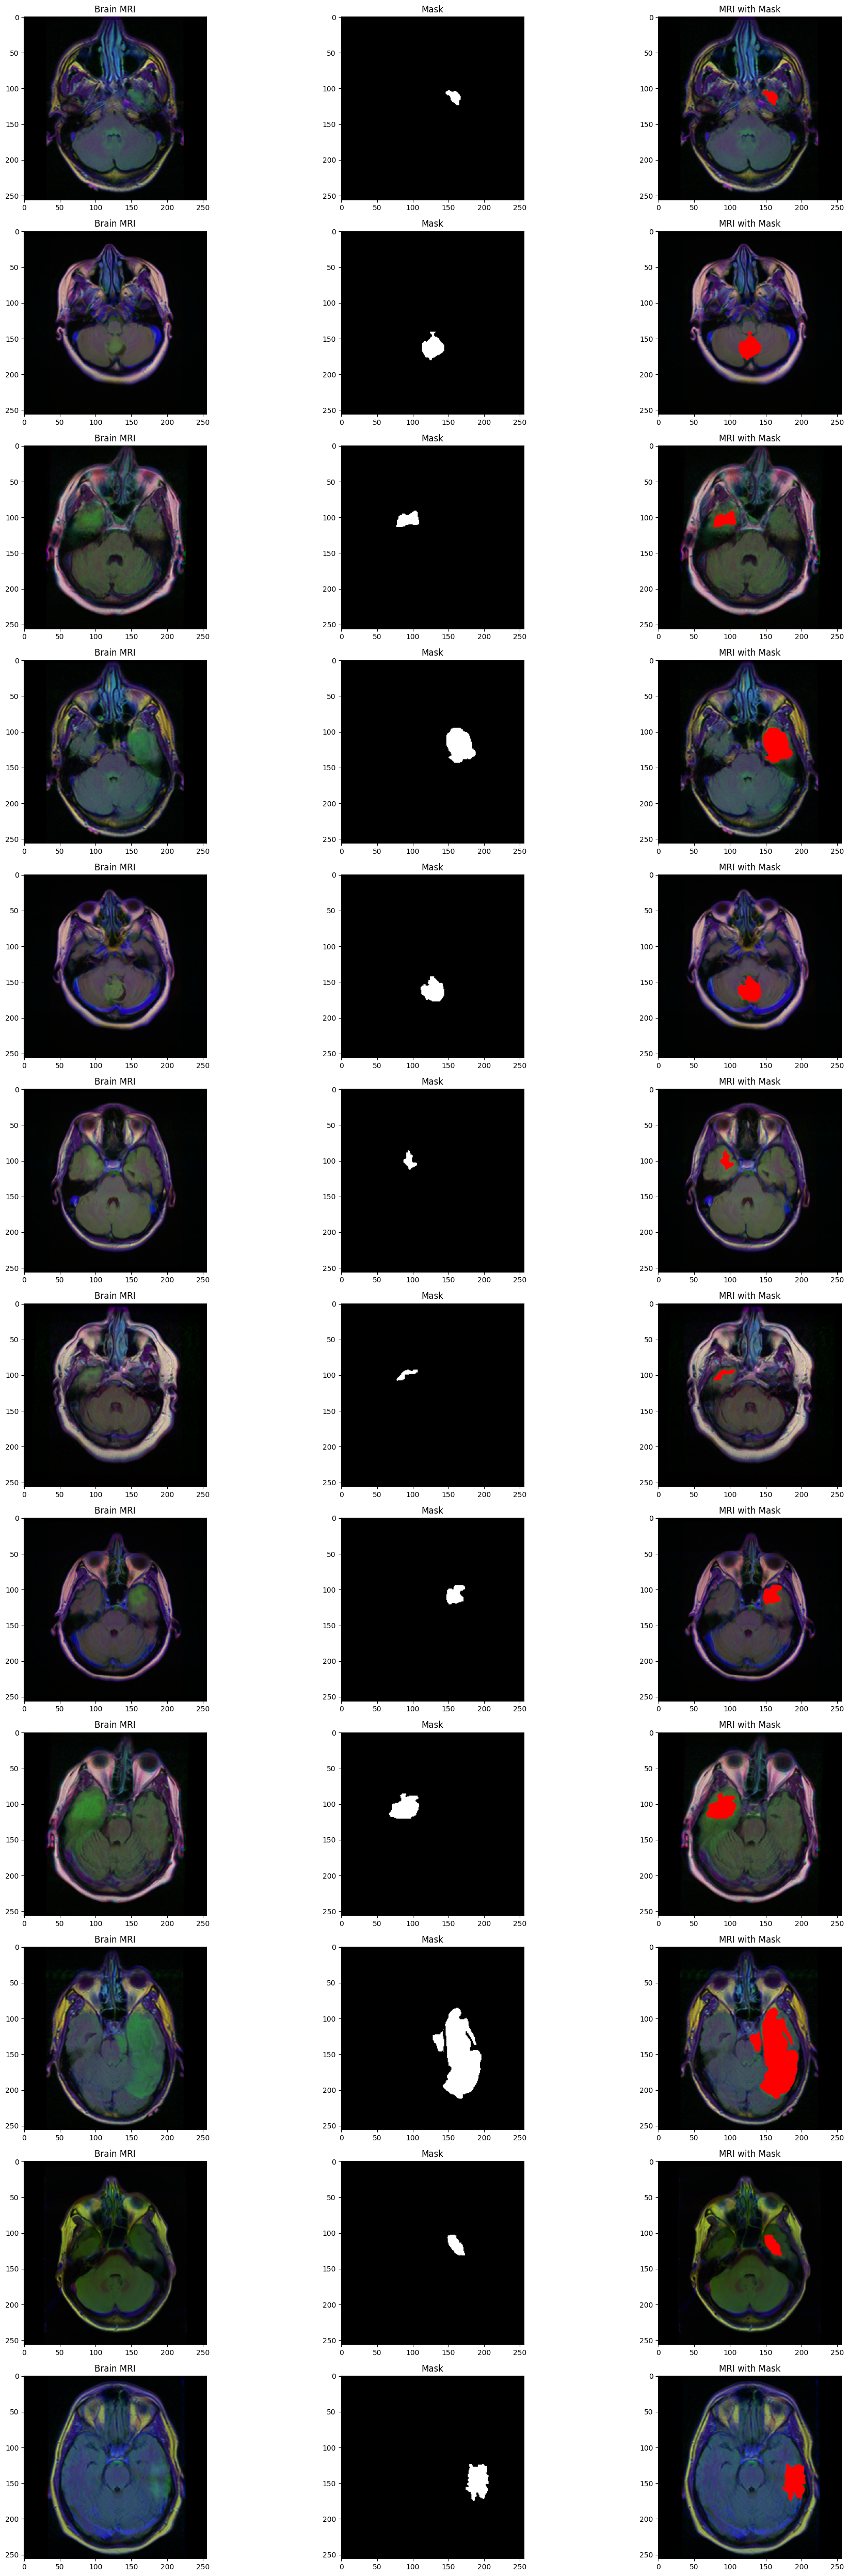

In [21]:
# Advanced Visualization: visualize the MRI scans along with their mask on one image
count = 0
fig, axs = plt.subplots(12,3, figsize=(20,50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 12:
  # read the images
    img = io.imread(brain_df.image_path[i])
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # obtain the mask for the image
    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text("Mask")
    axs[count][1].imshow(mask, cmap = 'gray')

    # replace the values in the image with red color (255,0,0) if any mask pixel in the mask was = 255
    img[mask == 255] = (255,0,0)
    axs[count][2].title.set_text("MRI with Mask")
    axs[count][2].imshow(img)
    count += 1

fig.tight_layout()

## Training a classifier model to detect tumor exist or not

In [65]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [66]:
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [173]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [174]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [175]:
!pip install keras_preprocessing

In [176]:
# create a image generator
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)


In [177]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))



Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [178]:
# Get the ResNet50 base model
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

In [179]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [180]:
# freeze the model weights

for layer in basemodel.layers:
  layers.trainable = False

In [181]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [182]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 25,751,426 (98.23 MB)

 Trainable params: 25,698,306 (98.03 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [183]:
# compile the model

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [184]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.keras", verbose=1, save_best_only=True)

In [185]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 50, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.6733 - loss: 1.0658
Epoch 1: val_loss improved from inf to 0.66432, saving model to classifier-resnet-weights.keras
177/177 ━━━━━━━━━━━━━━━━━━━━ 131s 422ms/step - accuracy: 0.6734 - loss: 1.0644 - val_accuracy: 0.6250 - val_loss: 0.6643
Epoch 2/50
  1/177 ━━━━━━━━━━━━━━━━━━━━ 45s 257ms/step - accuracy: 0.7500 - loss: 0.4364

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.




Epoch 2: val_loss did not improve from 0.66432
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7500 - loss: 0.4364 - val_accuracy: 0.6230 - val_loss: 0.6661
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.7679 - loss: 0.4439
Epoch 3: val_loss did not improve from 0.66432
177/177 ━━━━━━━━━━━━━━━━━━━━ 82s 463ms/step - accuracy: 0.7680 - loss: 0.4439 - val_accuracy: 0.6210 - val_loss: 0.6947
Epoch 4/50
  1/177 ━━━━━━━━━━━━━━━━━━━━ 33s 189ms/step - accuracy: 0.5625 - loss: 0.4377
Epoch 4: val_loss did not improve from 0.66432
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5625 - loss: 0.4377 - val_accuracy: 0.6210 - val_loss: 0.6859
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.7925 - loss: 0.4191
Epoch 5: val_loss did not improve from 0.66432
177/177 ━━━━━━━━━━━━━━━━━━━━ 39s 219ms/step - accuracy: 0.7926 - loss: 0.4190 - val_accuracy: 0.6250 - val_loss: 0.7079
Epoch 6/50
  1/177 ━━━━━━━━━━━━━━━━━━━━ 33s 188ms/step - accuracy: 1.0

In [186]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

In [187]:
# After training
model.save("resnet-50-MRI-full.keras")


## Evaluation

In [188]:
# make prediction
test_predict = model.predict(test_generator,
                             steps=test_generator.n // test_generator.batch_size,
                             verbose=1)


36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 314ms/step


In [189]:
test_predict.shape

(576, 2)

In [190]:
print(np.bincount(train_generator.classes))  # How many images per class?


[1857  982]


In [191]:
test_predict

array([[1.0000000e+00, 1.9721513e-11],
       [9.9998939e-01, 1.0607724e-05],
       [9.8612112e-01, 1.3878833e-02],
       ...,
       [9.9996758e-01, 3.2384163e-05],
       [8.1682277e-01, 1.8317722e-01],
       [7.5476664e-01, 2.4523328e-01]], dtype=float32)

In [192]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [193]:
predict

array(['0', '0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '0', '1',
       '1', '1', '0', '0', '0', '1', '1', '1', '1', '0', '0', '1', '0',
       '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '1', '0', '1',
       '1', '0', '1', '1', '0', '0', '0', '1', '0', '1', '0', '0', '1',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0',
       '1', '1', '0', '1', '0', '1', '1', '0', '1', '1', '1', '1', '0',
       '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0',
       '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '1', '1', '1',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1',
       '0', '0', '1', '1', '0', '1', '1', '0', '0', '0', '0', '0', '0',
       '1', '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0',
       '0', '1', '1', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1

In [194]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [195]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9496527777777778

<Axes: >

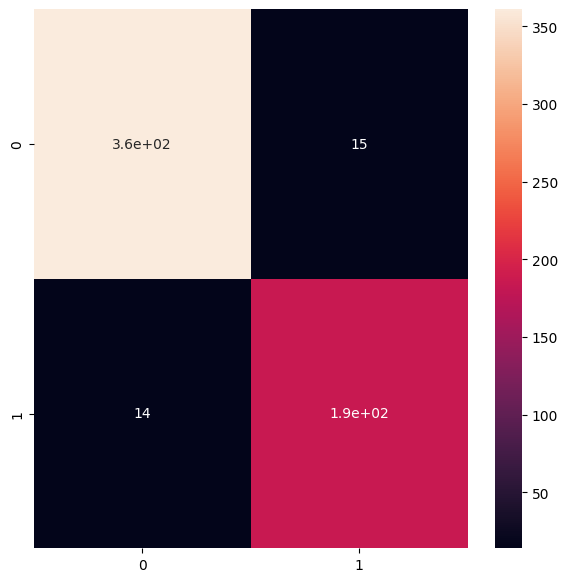

In [196]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

### Classification report

In [197]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       376
           1       0.93      0.93      0.93       200

   micro avg       0.95      0.95      0.95       576
   macro avg       0.94      0.95      0.94       576
weighted avg       0.95      0.95      0.95       576



## Building a segmentation model to localize tumor

In [198]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [199]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [200]:
# create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [201]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import DataGenerator

# create image generators

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [202]:
def resblock(X, f):


  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [203]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [204]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


## Segmentation model summary

In [205]:
model_seg.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_5[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 256, 256,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 128, 128,  │        544 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 128, 128,  │      9,248 │ activation_16[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 128, 128,  │        544 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 128, 128,  │          0 │ add_8[0][0]       │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ activation_17[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 64, 64,    │      2,112 │ max_pooling2d_5[

 Total params: 1,210,513 (4.62 MB)

 Trainable params: 1,206,129 (4.60 MB)

 Non-trainable params: 4,384 (17.12 KB)

## Training a segmentation resunet model to localize tumor

In [206]:
# Utilities file contains the code for custom loss function and custom data generator

from utilities import focal_tversky, tversky_loss, tversky

In [207]:
adam = tf.keras.optimizers.Adam(learning_rate=0.05, epsilon=0.1)
model_seg.compile(optimizer=adam, loss=focal_tversky, metrics=[tversky])


In [208]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.keras", verbose=1, save_best_only=True)

In [209]:
history = model_seg.fit(training_generator, epochs = 50, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - loss: 0.8968 - tversky: 0.1349

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.




Epoch 1: val_loss improved from inf to 0.80790, saving model to ResUNet-weights.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 76s 642ms/step - loss: 0.8963 - tversky: 0.1354 - val_loss: 0.8079 - val_tversky: 0.2471
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.6573 - tversky: 0.4244
Epoch 2: val_loss improved from 0.80790 to 0.50965, saving model to ResUNet-weights.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 242ms/step - loss: 0.6559 - tversky: 0.4260 - val_loss: 0.5097 - val_tversky: 0.5925
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.4090 - tversky: 0.6943
Epoch 3: val_loss improved from 0.50965 to 0.48753, saving model to ResUNet-weights.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 218ms/step - loss: 0.4088 - tversky: 0.6944 - val_loss: 0.4875 - val_tversky: 0.6157
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.3423 - tversky: 0.7590
Epoch 4: val_loss improved from 0.48753 to 0.36306, saving model to ResUNet-weights.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 219ms/ste

In [210]:
# save the model architecture to json file for future use

model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

## Segmentation Model Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━

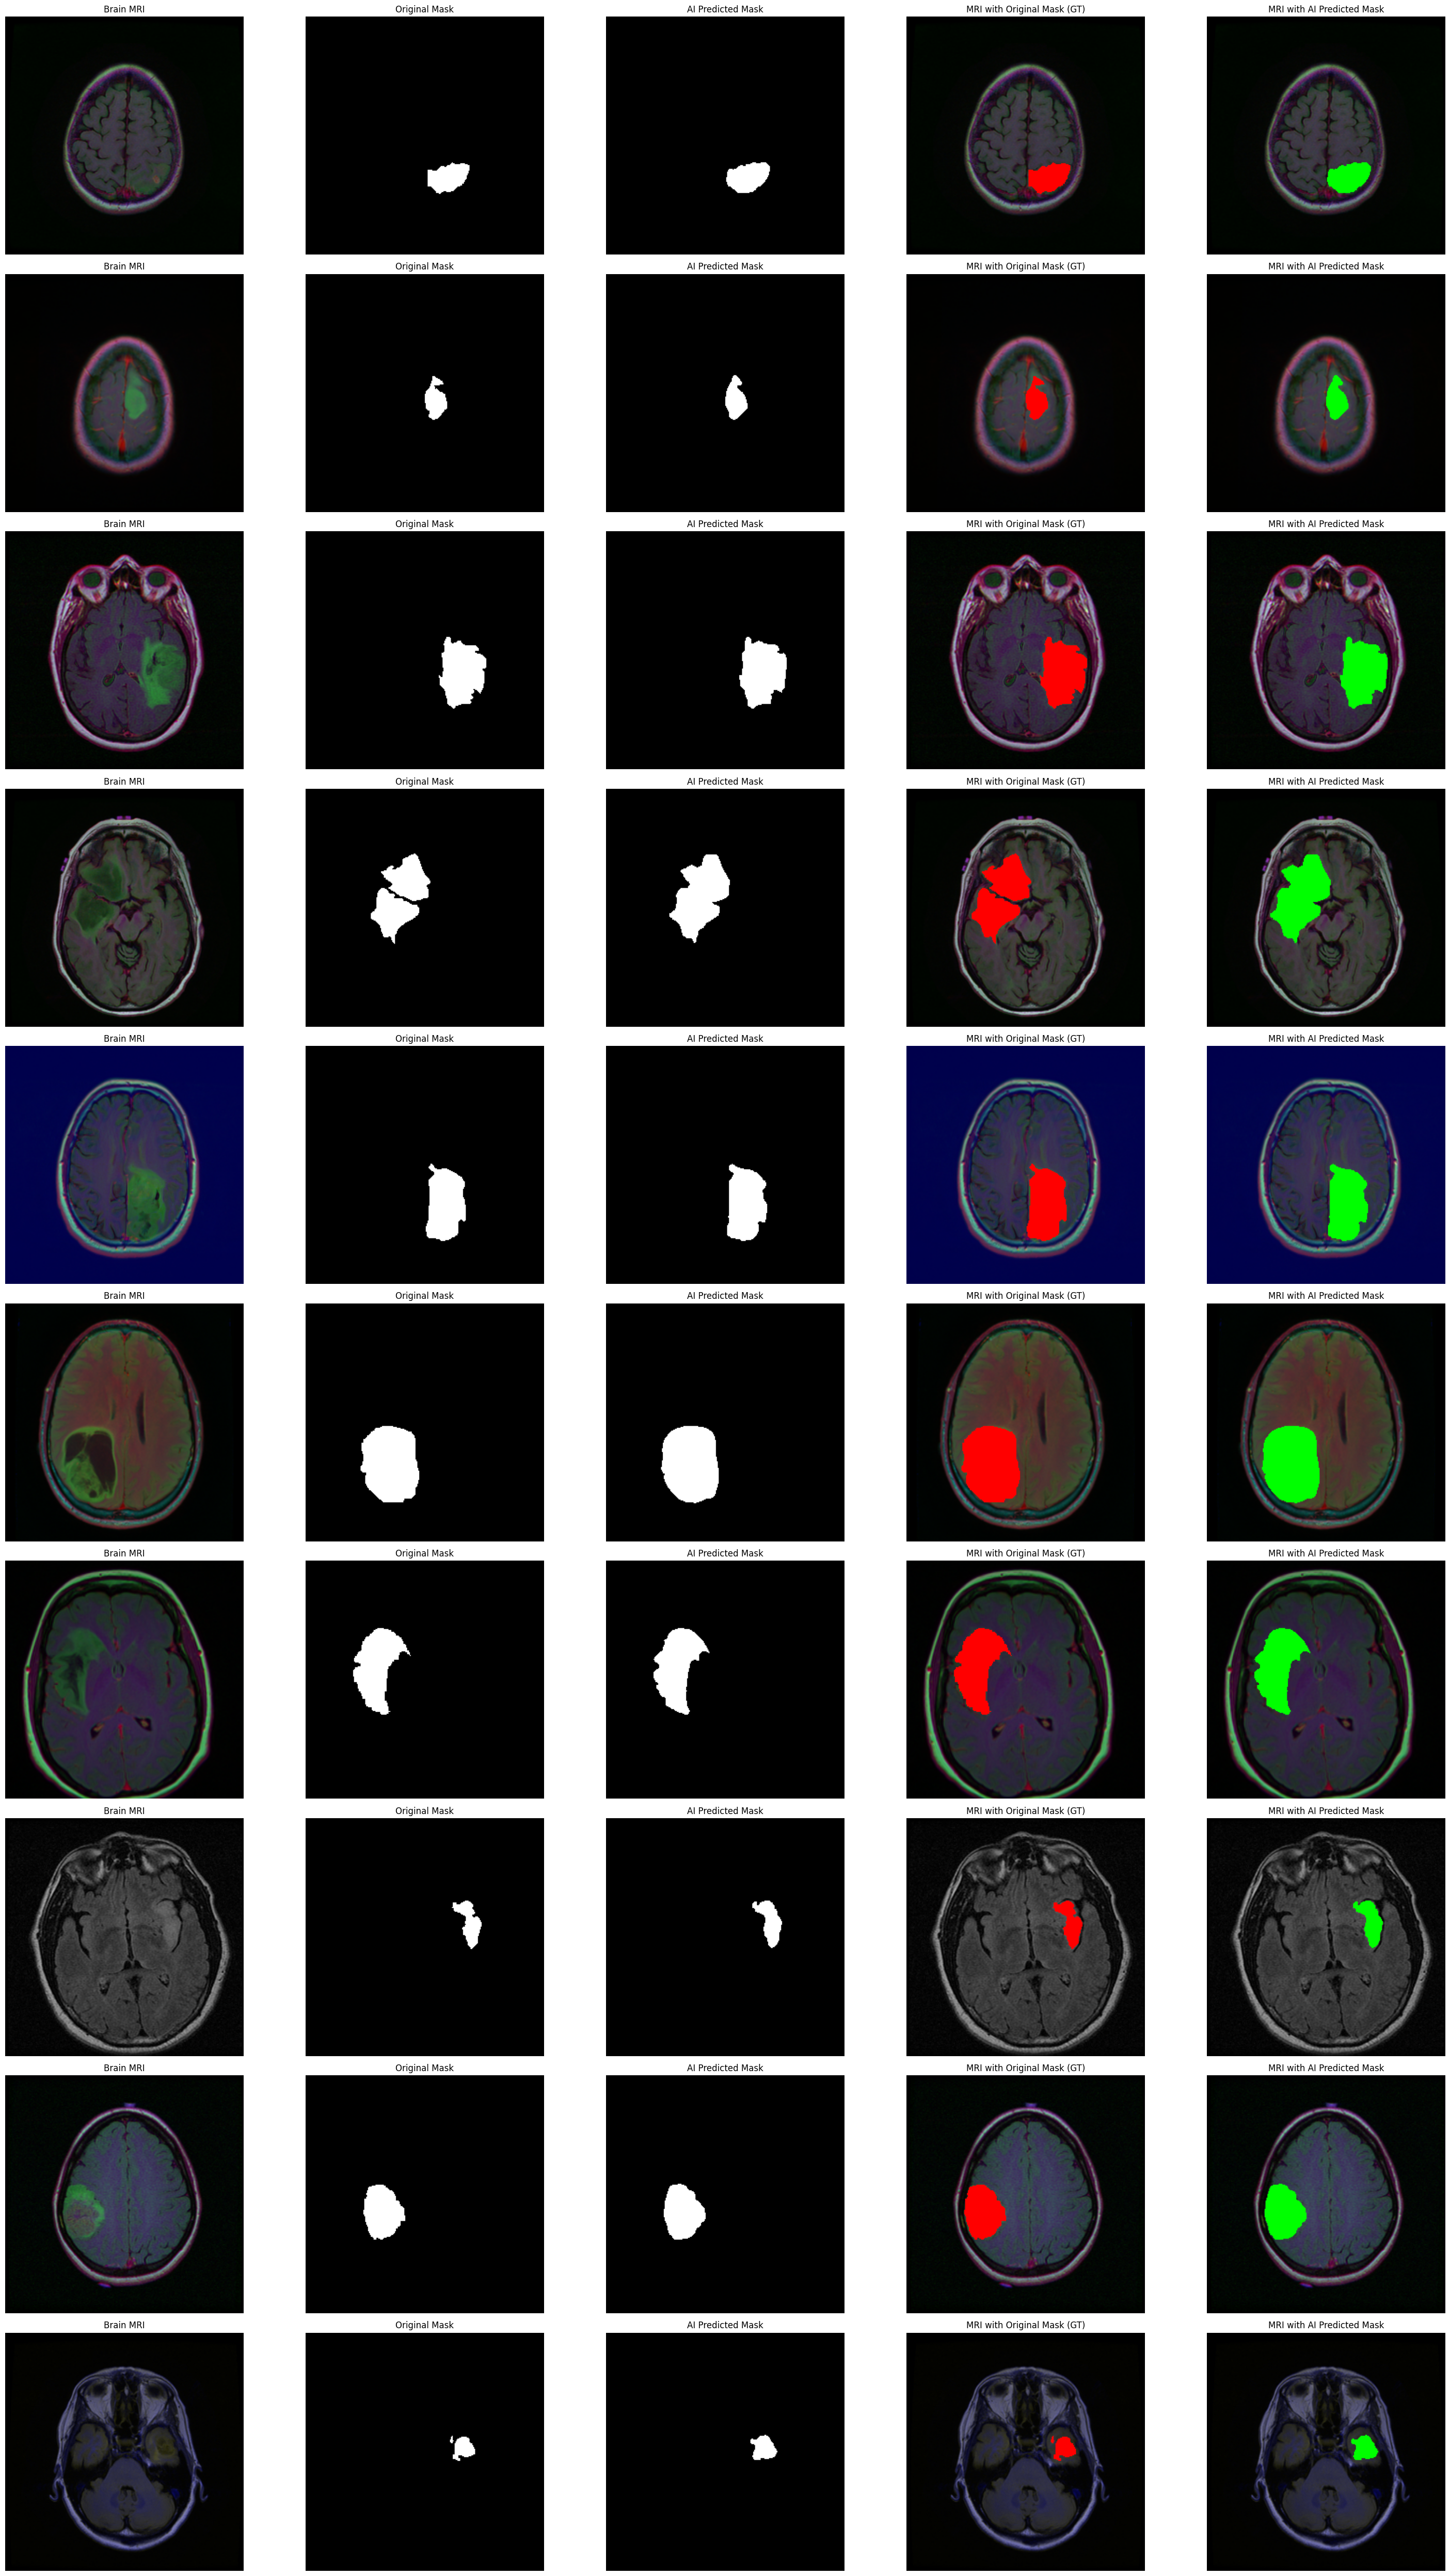

In [211]:
import matplotlib.pyplot as plt
from skimage import io
import cv2
import numpy as np
import pandas as pd

# --- Create DataFrame of predictions ---
image_id, mask, has_mask = prediction(test, model, model_seg)

df_pred = pd.DataFrame({
    'image_path': image_id,
    'predicted_mask': mask,
    'has_mask': has_mask
})

# --- Merge with original test DataFrame ---
df_pred = test.merge(df_pred, on='image_path', how='left')  # left join to keep all test images

# --- Check that mask_path exists ---
if 'mask_path' not in df_pred.columns:
    print("Warning: 'mask_path' column not found in merged DataFrame. Overlaying original mask will be skipped.")

# --- Plotting ---
count = 0
fig, axs = plt.subplots(10, 5, figsize=(30, 50))

for i in range(len(df_pred)):
    if df_pred['has_mask'].iloc[i] == 1 and count < 10:
        # Load original MRI image
        img = io.imread(df_pred.loc[i, 'image_path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].set_title("Brain MRI")
        axs[count][0].axis('off')

        # Original mask (if available)
        if 'mask_path' in df_pred.columns and pd.notna(df_pred.loc[i, 'mask_path']):
            mask = io.imread(df_pred.loc[i, 'mask_path'])
            axs[count][1].imshow(mask, cmap='gray')
            axs[count][1].set_title("Original Mask")
            axs[count][1].axis('off')
        else:
            mask = None
            axs[count][1].set_title("Original Mask not available")
            axs[count][1].axis('off')

        # Predicted mask
        predicted_mask = np.asarray(df_pred.loc[i, 'predicted_mask'])[0].squeeze().round()
        axs[count][2].imshow(predicted_mask, cmap='gray')
        axs[count][2].set_title("AI Predicted Mask")
        axs[count][2].axis('off')

        # Overlay original mask in red
        img_overlay = img.copy()
        if mask is not None:
            img_overlay[mask == 255] = (255, 0, 0)
        axs[count][3].imshow(img_overlay)
        axs[count][3].set_title("MRI with Original Mask (GT)")
        axs[count][3].axis('off')

        # Overlay predicted mask in green
        img_pred_overlay = img.copy()
        img_pred_overlay[predicted_mask == 1] = (0, 255, 0)
        axs[count][4].imshow(img_pred_overlay)
        axs[count][4].set_title("MRI with AI Predicted Mask")
        axs[count][4].axis('off')

        count += 1

fig.tight_layout()
plt.show()
